In [ ]:
import random
random.seed(0)
import numpy as np
np.random.seed(0)
import tensorflow as tf
tf.random.set_seed(0)

In [ ]:
import os
import json
from zipfile import ZipFile
from PIL import Image
import numpy as np
import pandas as pd
from tensorflow.keras import layers,models

In [ ]:
!pip install kaggle

In [ ]:
kaggle_credentials=json.load(open('/content/kaggle (1).json'))

In [ ]:
os.environ['KAGGLE_USERNAME']=kaggle_credentials['username']
os.environ['KAGGLE_KEY']=kaggle_credentials['key']

In [ ]:
!kaggle datasets download brycecf/give-me-some-credit-dataset

Dataset URL: https://www.kaggle.com/datasets/brycecf/give-me-some-credit-dataset
License(s): unknown
give-me-some-credit-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
with ZipFile ('give-me-some-credit-dataset.zip','r') as zip_ref:
  zip_ref.extractall()

In [ ]:
testdata=pd.read_csv('/content/cs-test.csv')
testdata.head()


,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [ ]:
traindata=pd.read_csv('/content/cs-training.csv')
traindata.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [ ]:
traindata['NumberOfLatePayments']=traindata['SeriousDlqin2yrs']+traindata['NumberOfTime30-59DaysPastDueNotWorse']+traindata['NumberOfTimes90DaysLate']+traindata['NumberOfTime60-89DaysPastDueNotWorse']

In [ ]:
traindata['IncomePerPerson']=traindata['MonthlyIncome']/(1+traindata['NumberOfDependents'])

In [ ]:
traindata=traindata.drop(columns={'MonthlyIncome','NumberOfDependents','NumberOfTime30-59DaysPastDueNotWorse','NumberOfTimes90DaysLate','NumberOfTime60-89DaysPastDueNotWorse'})

In [ ]:
traindata=traindata.drop(columns={'Unnamed: 0','SeriousDlqin2yrs'})

In [ ]:
traindata.head()

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfLatePayments,IncomePerPerson
0,0.766127,45,0.802982,13,6,3,3040.0
1,0.957151,40,0.121876,4,0,0,1300.0
2,0.658180,38,0.085113,2,0,2,3042.0
3,0.233810,30,0.036050,5,0,0,3300.0
4,0.907239,49,0.024926,7,1,1,63588.0


In [ ]:
def calculate_risk(row):
    score = 0
    if row['DebtRatio'] > 0.6:
        score += 2
    elif row['DebtRatio'] > 0.3:
        score += 1
    if row['RevolvingUtilizationOfUnsecuredLines'] > 1.0:
        score += 2
    elif row['RevolvingUtilizationOfUnsecuredLines'] > 0.5:
        score += 1
    delinquencies = row['NumberOfLatePayments']
    if delinquencies > 3:
        score += 2
    elif delinquencies > 0:
        score += 1
    if score <= 2:
        return 0  # Low Risk
    elif score <= 4:
        return 1  # Medium Risk
    else:
        return 2  # High Risk

In [ ]:
traindata['RiskLevel'] = traindata.apply(calculate_risk, axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
X = traindata.drop(columns=[ 'RiskLevel'])
Y = traindata['RiskLevel']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

In [ ]:
X_train.isnull().sum()

,0
RevolvingUtilizationOfUnsecuredLines,0
age,0
DebtRatio,0
NumberOfOpenCreditLinesAndLoans,0
NumberRealEstateLoansOrLines,0
NumberOfLatePayments,0
IncomePerPerson,23798


In [ ]:
X_train = X_train.copy()
X_train['IncomePerPerson'] = X_train['IncomePerPerson'].fillna(0)

In [ ]:
X_test.isnull().sum()

,0
RevolvingUtilizationOfUnsecuredLines,0
age,0
DebtRatio,0
NumberOfOpenCreditLinesAndLoans,0
NumberRealEstateLoansOrLines,0
NumberOfLatePayments,0
IncomePerPerson,5933


In [ ]:
X_test = X_test.copy()
X_test['IncomePerPerson'] = X_test['IncomePerPerson'].fillna(0)

In [ ]:
Y_train.isnull().sum()

np.int64(0)

In [ ]:
Y_test.isnull().sum()

np.int64(0)

In [ ]:
X_train.duplicated().sum()

np.int64(655)

In [ ]:
Y_train.duplicated().sum()

np.int64(119997)

In [ ]:
train_combined = pd.concat([X_train, Y_train], axis=1)

# Step 2: Drop duplicate rows from the combined dataframe
train_combined_cleaned = train_combined.drop_duplicates()

# Step 3: Split them back into X_train and y_train
X_train = train_combined_cleaned.drop(columns=[Y_train.name])  # Drop target column from features
Y_train = train_combined_cleaned[Y_train.name]

In [ ]:
X_train.shape

(119345, 7)

In [ ]:
Y_train.shape

(119345,)

In [ ]:
X_test.shape

(30000, 7)

In [ ]:
Y_test.shape

(30000,)

In [ ]:
X_train.head()

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfLatePayments,IncomePerPerson
72390,0.038585,67,0.230396,11,3,0,7000.0
12838,0.059672,52,2675.000000,14,1,0,0.0
109325,0.009346,75,0.001217,2,0,0,821.0
292,0.679814,83,0.689590,6,2,0,4216.0
112910,0.823113,51,0.537720,12,2,2,5500.0


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
traindata['RiskLevel'].value_counts()

,count
RiskLevel,
0,123604
1,24207
2,2189


<ipython-input-34-ef07ff369cd7>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


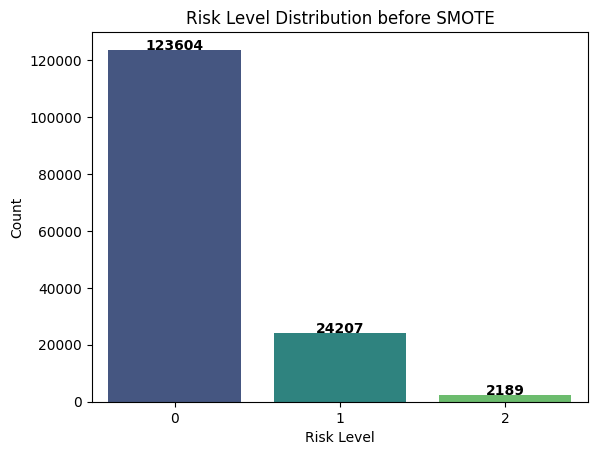

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
counts = traindata['RiskLevel'].value_counts()
sns.barplot(x=counts.index, y=counts.values, palette="viridis")

for i, val in enumerate(counts.values):
    plt.text(i, val + 100, str(val), ha='center', fontweight='bold')

plt.title("Risk Level Distribution before SMOTE")
plt.xlabel("Risk Level")
plt.ylabel("Count")
plt.show()


We can see that the model is extremely imbalanced here
so lets first fix that

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=1234)
x_train, y_train = smote.fit_resample(X_train, Y_train)


<ipython-input-36-c75d30f923e2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


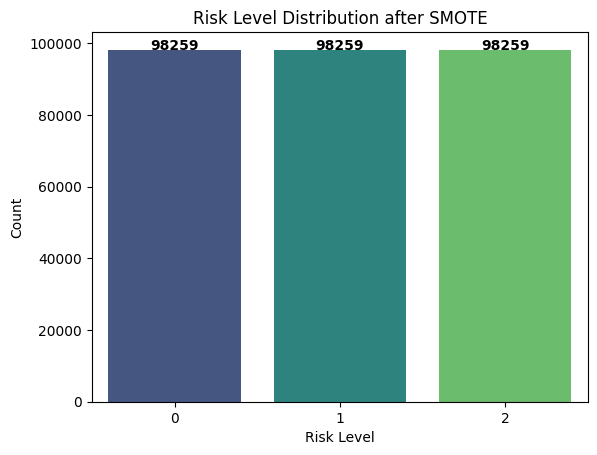

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
counts = y_train.value_counts()
sns.barplot(x=counts.index, y=counts.values, palette="viridis")

for i, val in enumerate(counts.values):
    plt.text(i, val + 100, str(val), ha='center', fontweight='bold')

plt.title("Risk Level Distribution after SMOTE")
plt.xlabel("Risk Level")
plt.ylabel("Count")
plt.show()


In [ ]:
#model building
import tensorflow as tf
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
tf.random.set_seed(1234)
model = Sequential([
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8,activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.002),
    metrics=['accuracy']
)
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# Add to model.fit
model.fit(x_train, y_train,
          epochs=10,
          validation_data=(X_test, Y_test),
          callbacks=[early_stop])

Epoch 1/10
9212/9212 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.7484 - loss: 0.5591 - val_accuracy: 0.8295 - val_loss: 0.4327
Epoch 2/10
9212/9212 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.8064 - loss: 0.4490 - val_accuracy: 0.8427 - val_loss: 0.3916
Epoch 3/10
9212/9212 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - accuracy: 0.8268 - loss: 0.4036 - val_accuracy: 0.8378 - val_loss: 0.3513
Epoch 4/10
9212/9212 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.8586 - loss: 0.3322 - val_accuracy: 0.8790 - val_loss: 0.2505
Epoch 5/10
9212/9212 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.8795 - loss: 0.2825 - val_accuracy: 0.8731 - val_loss: 0.2695
Epoch 6/10
9212/9212 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.8883 - loss: 0.2636 - val_accuracy: 0.8796 - val_loss: 0.2570
Epoch 7/10
9212/9212 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.8933 - loss: 0.2510 - val_accuracy: 0.8884 - val_loss: 0.2352
Epoch 8/10
9212/9212 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.8950 - loss: 0

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print("Test Accuracy:", test_accuracy)

938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8930 - loss: 0.2237
Test Accuracy: 0.89246666431427


In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, y_pred, target_names=['Low', 'Medium', 'High']))


              precision    recall  f1-score   support

         Low       0.98      0.90      0.94     24736
      Medium       0.62      0.84      0.72      4837
        High       0.51      0.85      0.64       427

    accuracy                           0.89     30000
   macro avg       0.70      0.87      0.76     30000
weighted avg       0.92      0.89      0.90     30000



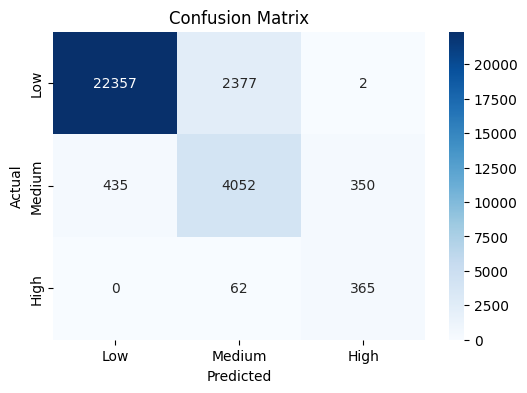

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Correct method for Keras model
model.save('credit_risk_model.h5')


In [ ]:
import joblib
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [ ]:
from google.colab import files
files.download('credit_risk_model.h5')
files.download('scaler.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>